In [34]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.cluster import KMeans # а также другие алгоритмы

In [35]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [36]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [37]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

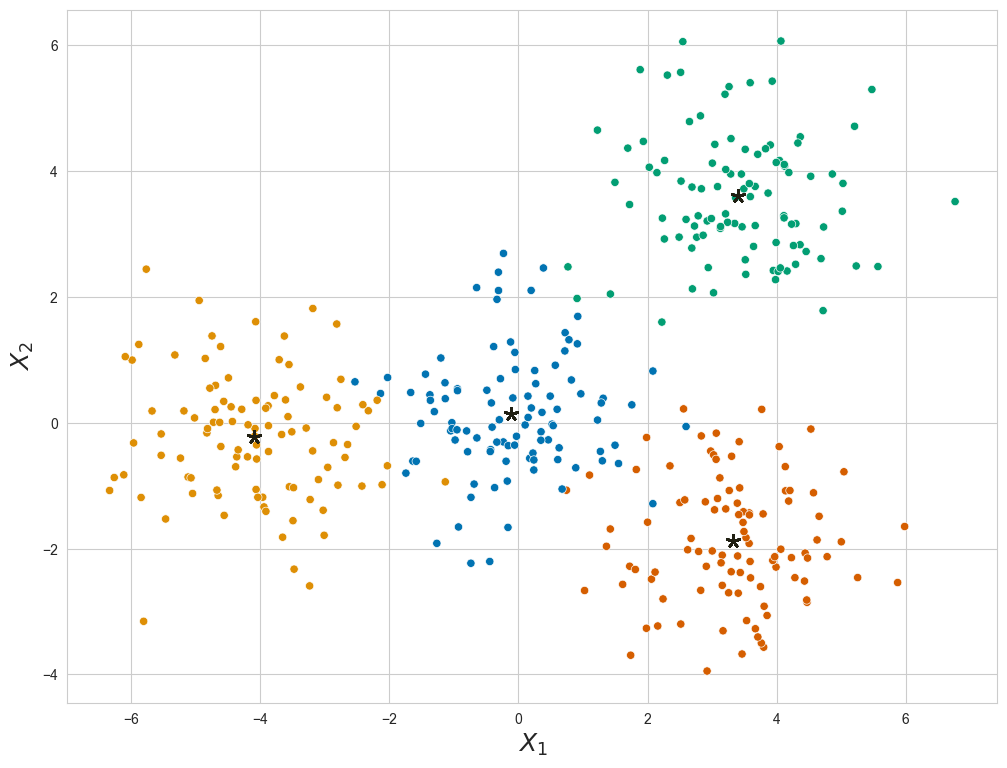

In [38]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [39]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        cluster_labels = np.argmin(dists, axis=1)
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
    
        dist = np.sqrt(np.sum((X - centroid) ** 2, axis=1))[:, np.newaxis]
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

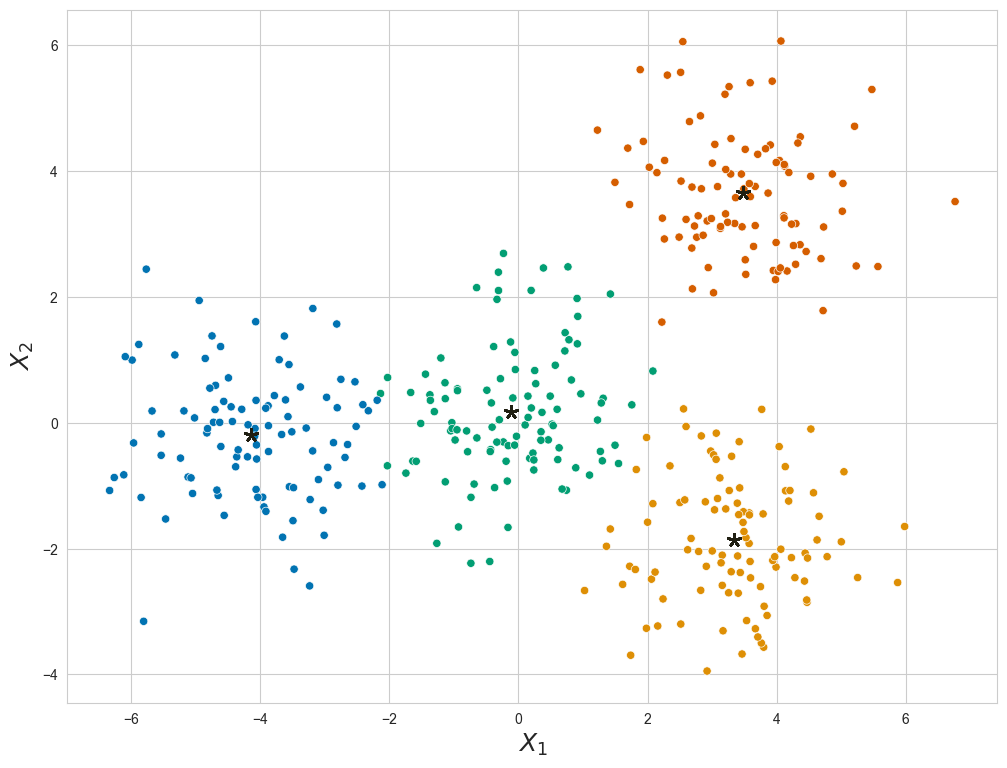

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [42]:
kmeans = MyKMeans(n_clusters=4, max_iter=10, visualize=True)
kmeans.fit(X)

Алгоритм сошелся за 5-6 итераций

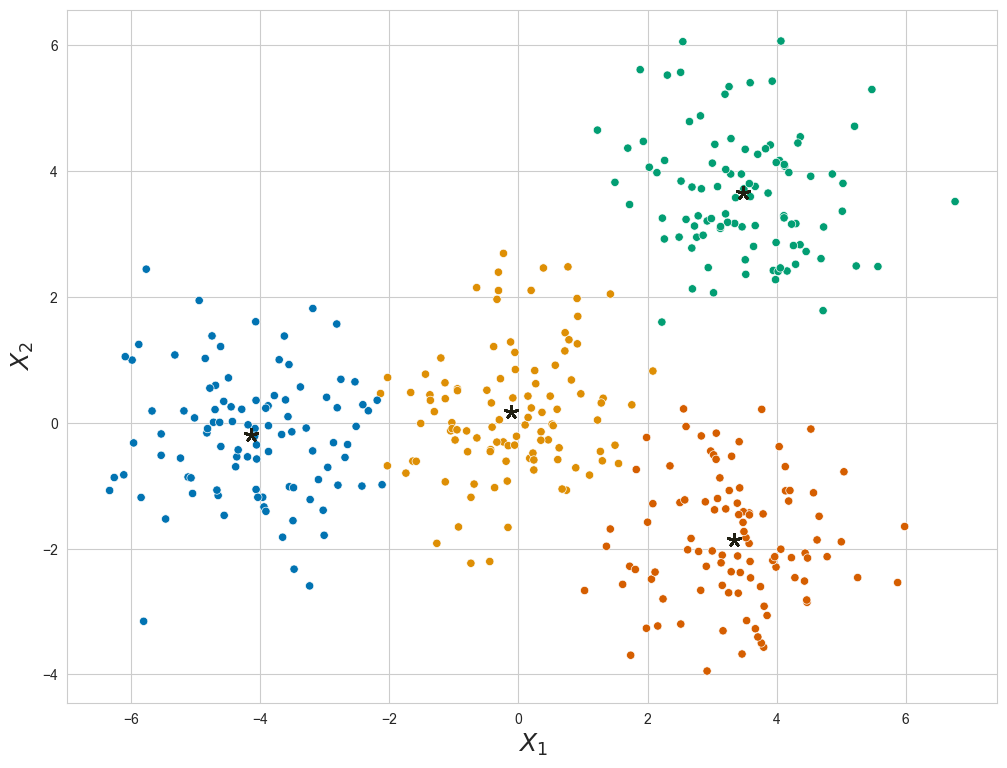

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [43]:
kmeans = MyKMeans(n_clusters=4, init="sample", max_iter=10, visualize=True)
kmeans.fit(X)

Алгоритм сходился 9-10 итераций, то есть сильно медленнее

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [44]:
data = load_digits()
X, y = data.data, data.target

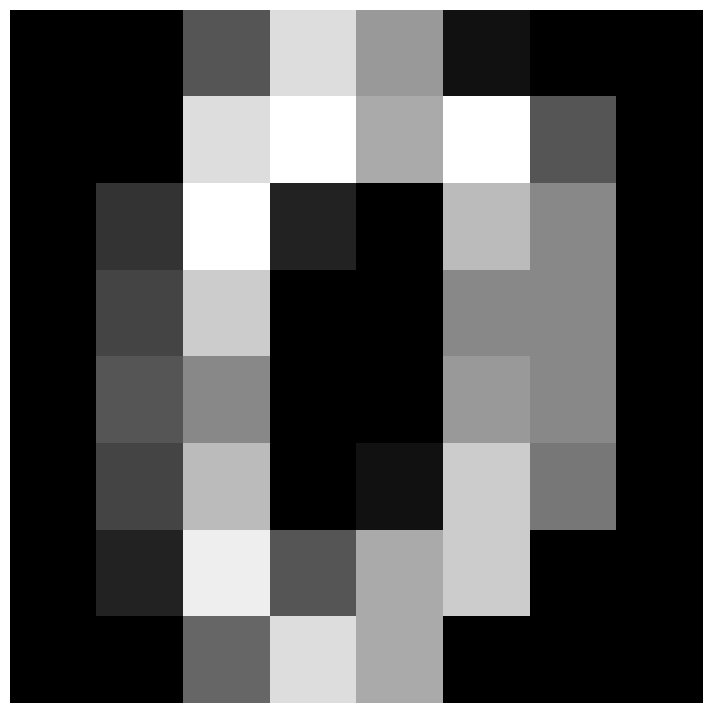

In [45]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [46]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score
from sklearn.metrics import pairwise_distances

def algorithm_selection(X, y, distances, algorithms, metrics):
    results = []
    distance_matrices = {dist: pairwise_distances(X, metric=dist) for dist in distances if dist != 'euclidean'}

    for distance in distances:
        for algorithm in algorithms:
            if distance != 'euclidean':
                clustering = AgglomerativeClustering(
                    linkage=algorithm,
                    metric='precomputed',
                    n_clusters=len(np.unique(y)))
                try:
                    labels = clustering.fit_predict(distance_matrices[distance])
                except:
                    continue
            else:
                clustering = AgglomerativeClustering(
                    linkage=algorithm,
                    metric='euclidean',
                    n_clusters=len(np.unique(y)))
                labels = clustering.fit_predict(X)

            scores = {
                'distance': distance,
                'linkage': algorithm,
                'homogeneity': homogeneity_score(y, labels) if 'homogeneity' in metrics else None,
                'completeness': completeness_score(y, labels) if 'completeness' in metrics else None,
                'v_measure': v_measure_score(y, labels) if 'v_measure' in metrics else None,
                'silhouette': silhouette_score(X, labels, metric=distance) if 'silhouette' in metrics else None
            }
            results.append(scores)

    return pd.DataFrame(results)

distances = ['euclidean', 'manhattan', 'cosine', 'l1'] 
linkage_methods = ['average', 'single', 'complete']  
quality_metrics = ['homogeneity', 'completeness', 'v_measure', 'silhouette'] 

compare_dataframe = algorithm_selection(X, y, distances, linkage_methods, quality_metrics)
print(compare_dataframe)

     distance   linkage  homogeneity  completeness  v_measure  silhouette
0   euclidean   average     0.655393      0.782342   0.713263    0.146625
1   euclidean    single     0.005056      0.273755   0.009929   -0.133621
2   euclidean  complete     0.590549      0.637772   0.613253    0.119271
3   manhattan   average     0.566751      0.778942   0.656117    0.105238
4   manhattan    single     0.005102      0.276237   0.010019   -0.203816
5   manhattan  complete     0.646372      0.686109   0.665648    0.160617
6      cosine   average     0.648268      0.808762   0.719676    0.218229
7      cosine    single     0.005050      0.273389   0.009916   -0.281789
8      cosine  complete     0.528727      0.577415   0.551999    0.144179
9          l1   average     0.566751      0.778942   0.656117    0.105238
10         l1    single     0.005102      0.276237   0.010019   -0.203816
11         l1  complete     0.646372      0.686109   0.665648    0.160617


Наилучшие результаты -- cosine + average, l1 + complete, euclidean  + average. Выберем cosine + average

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [47]:
df = pd.read_csv("flow_c_data.csv", index_col=0)

##### YOUR TURN TO CODE:

In [48]:
print(df.head())
print("Количество клеток:", df.shape[0])
print("Количество признаков:", df.shape[1])
print(df.describe())
print("Пропущенные данные по каждому признаку:")
print(df.isnull().sum())


      FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591  
Количество клеток: 10000
Количество признаков: 9
              FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7

Пропущенных данных нет. Почти везде есть явные выбросы, так что давайте клипнем 99 перцентиль

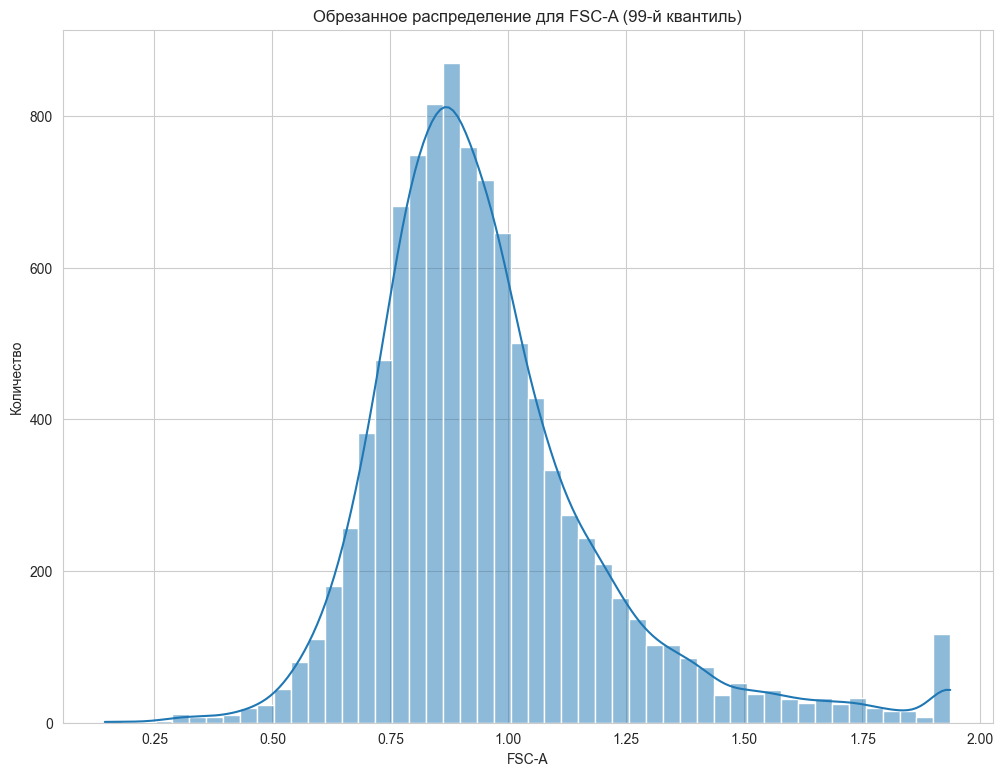

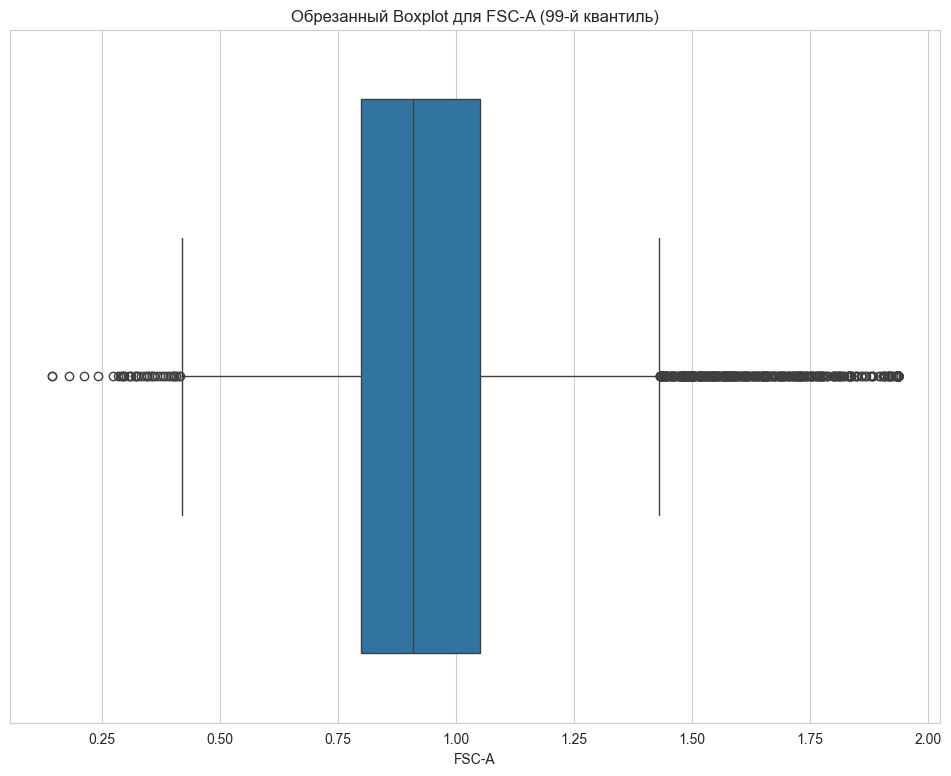

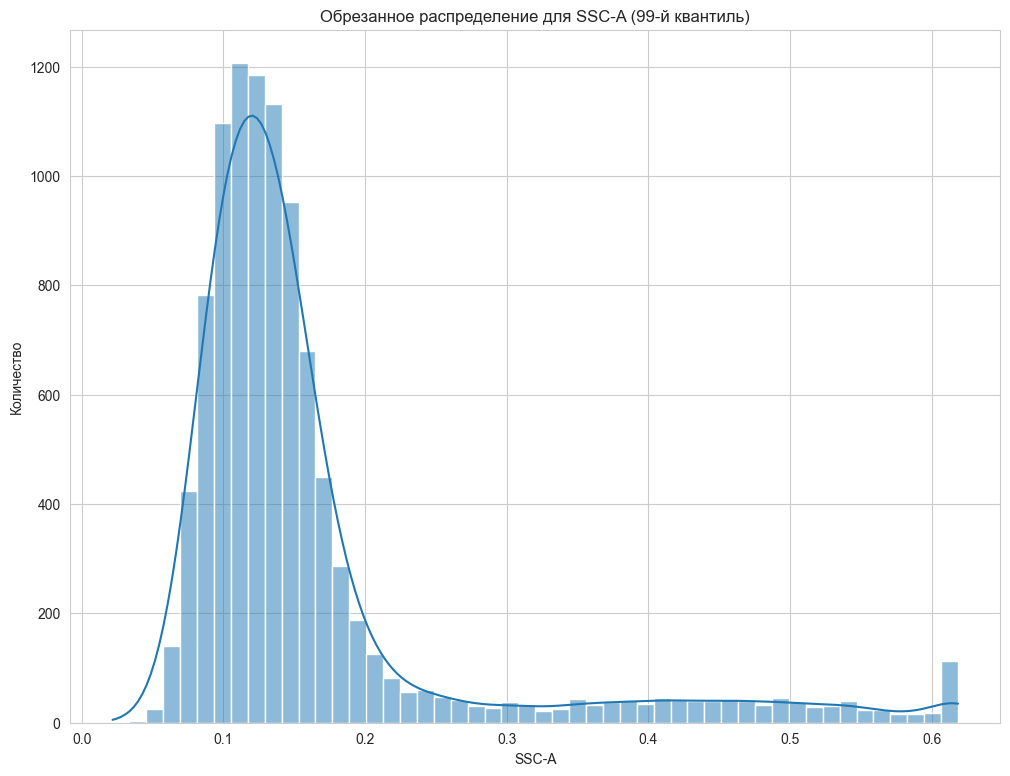

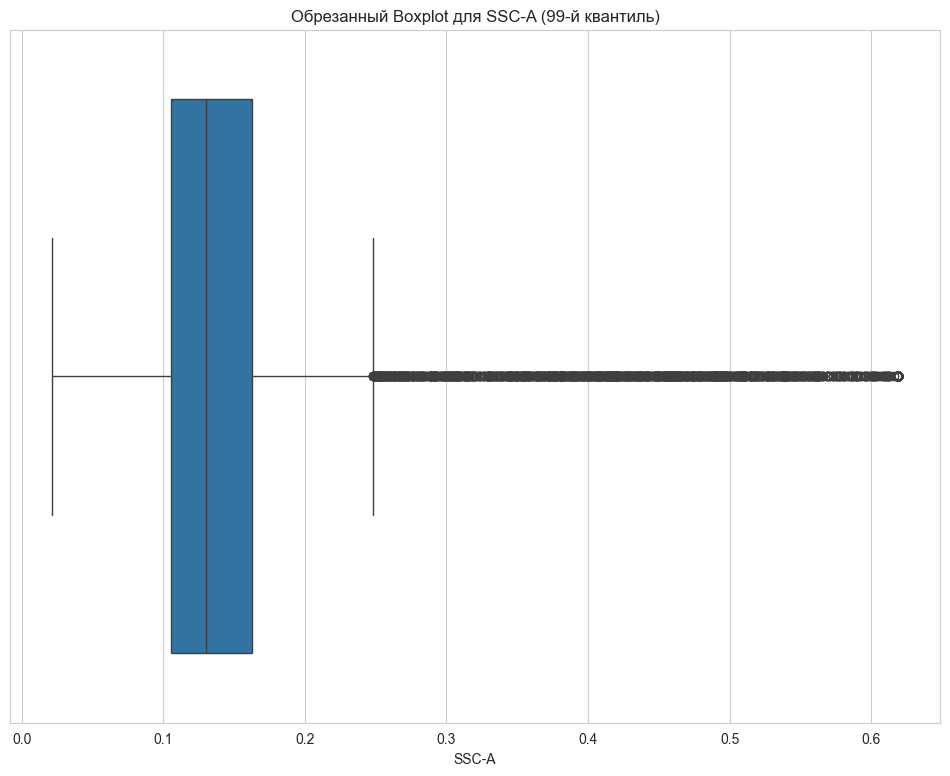

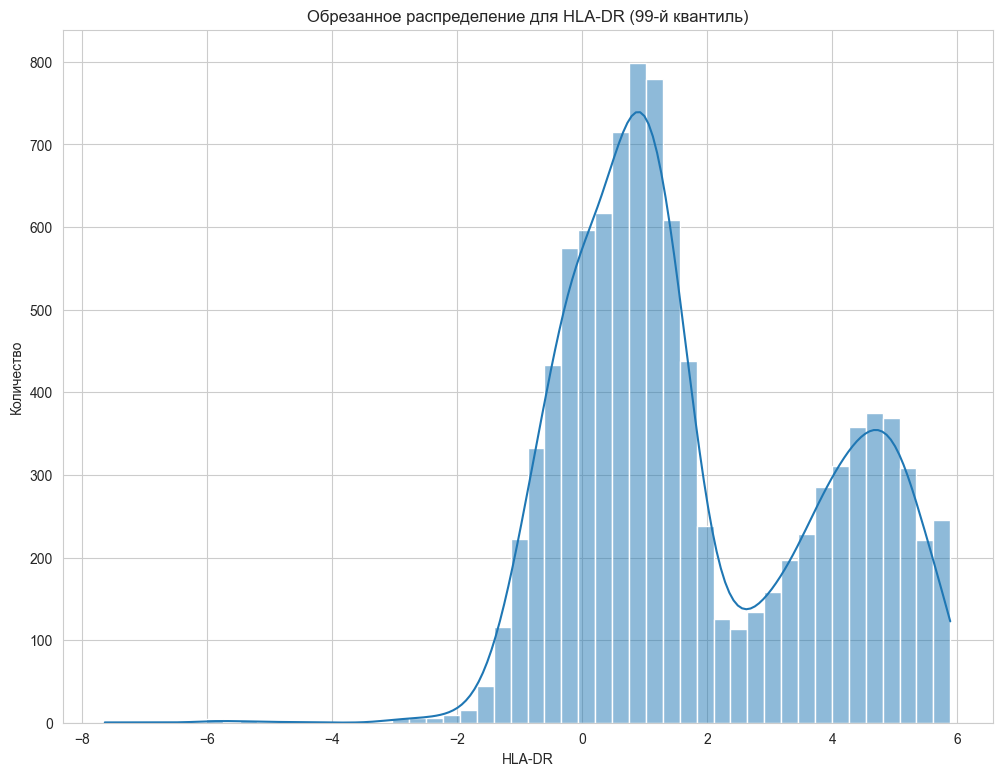

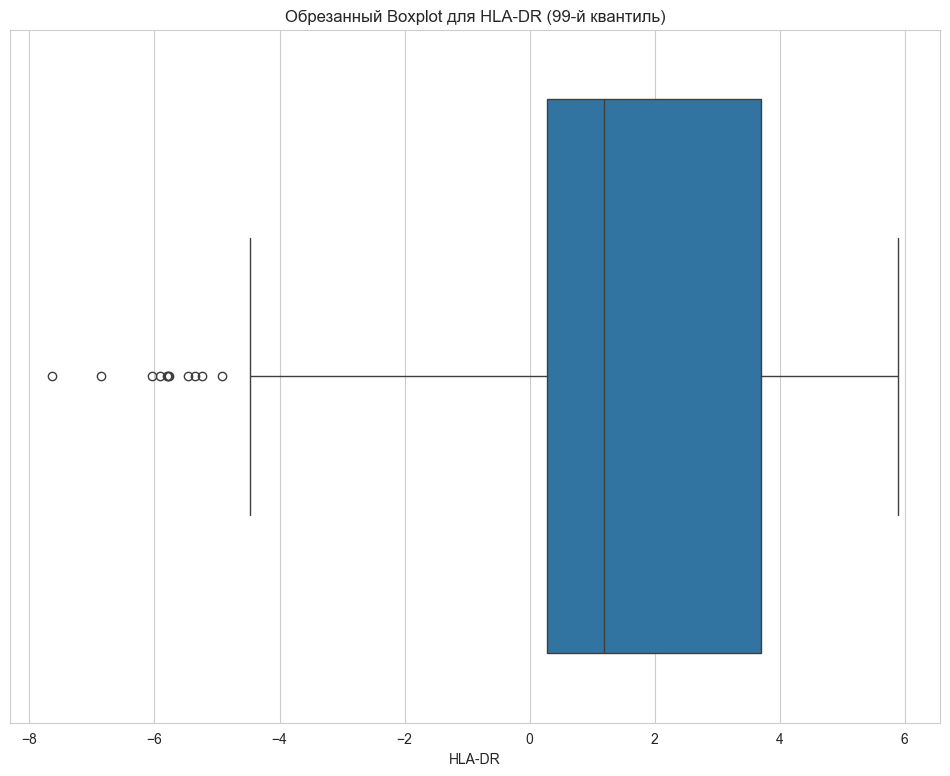

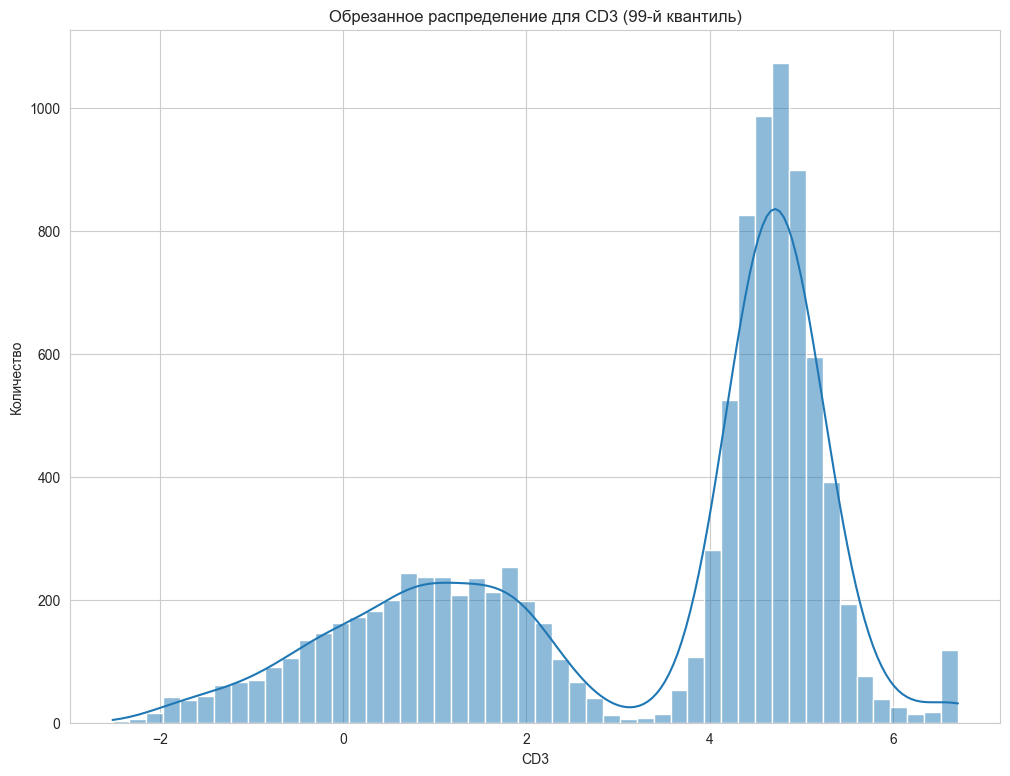

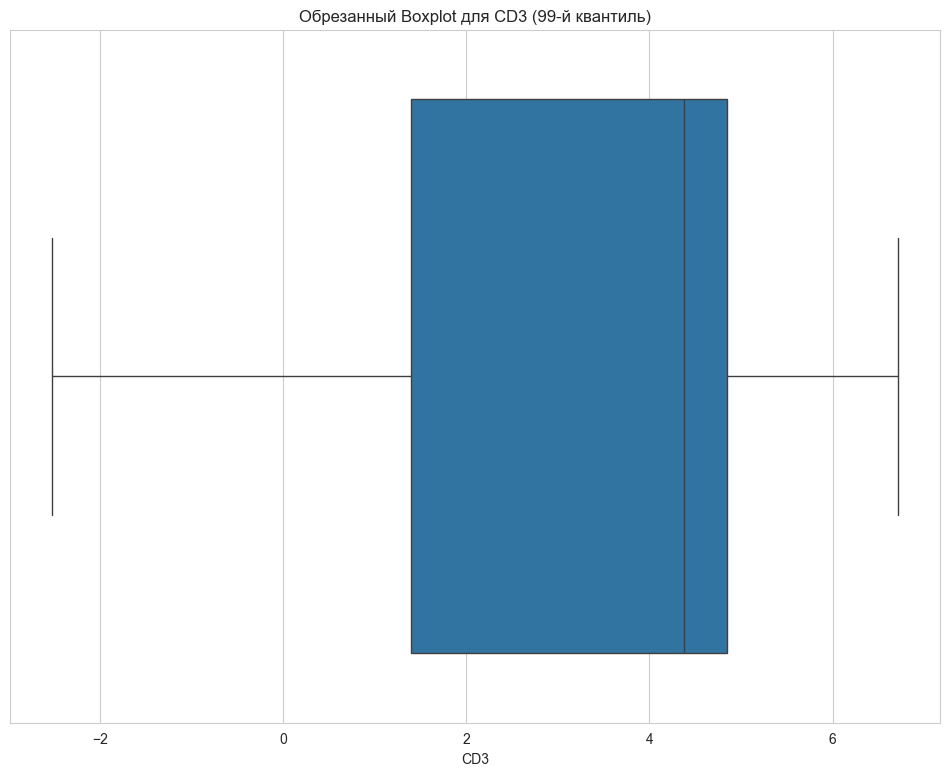

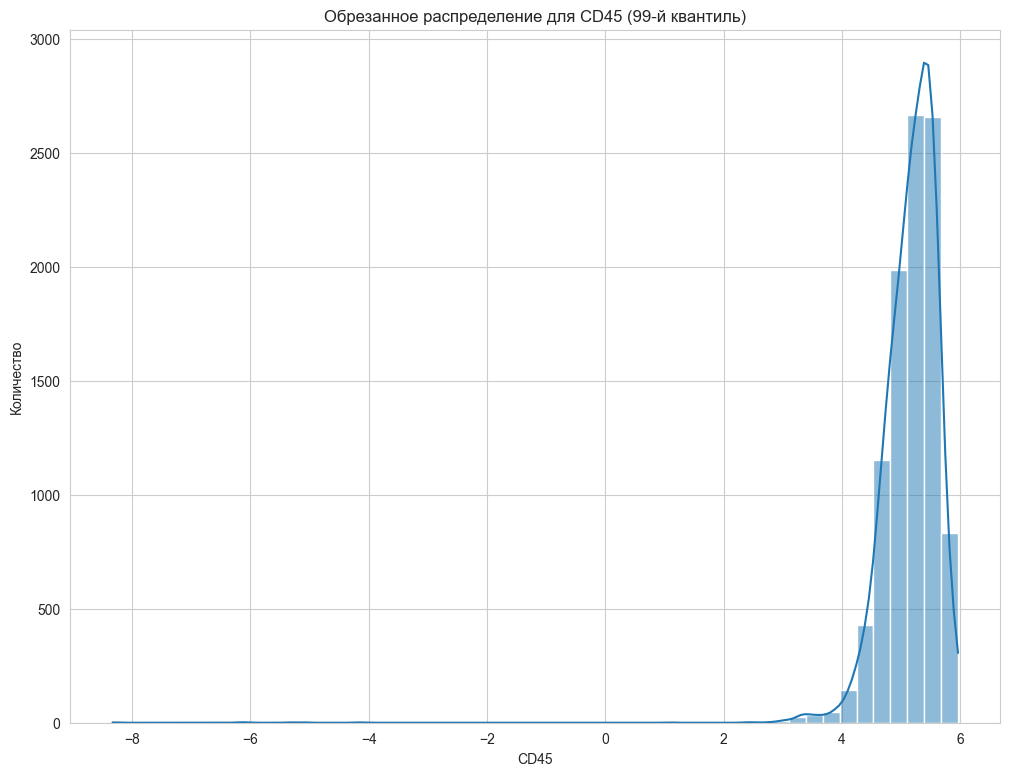

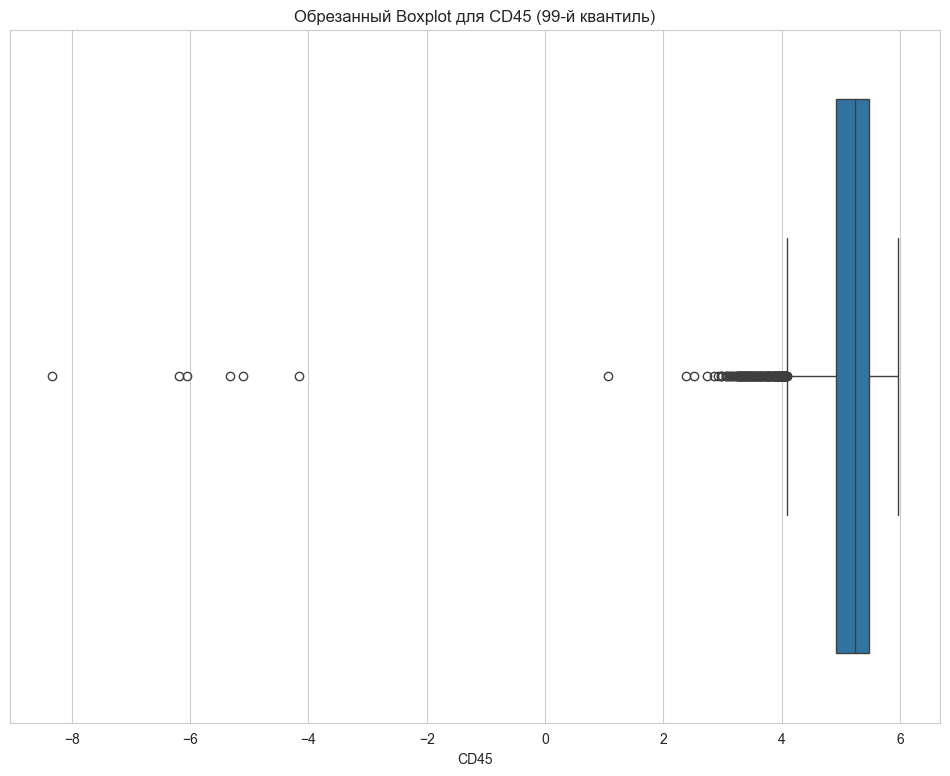

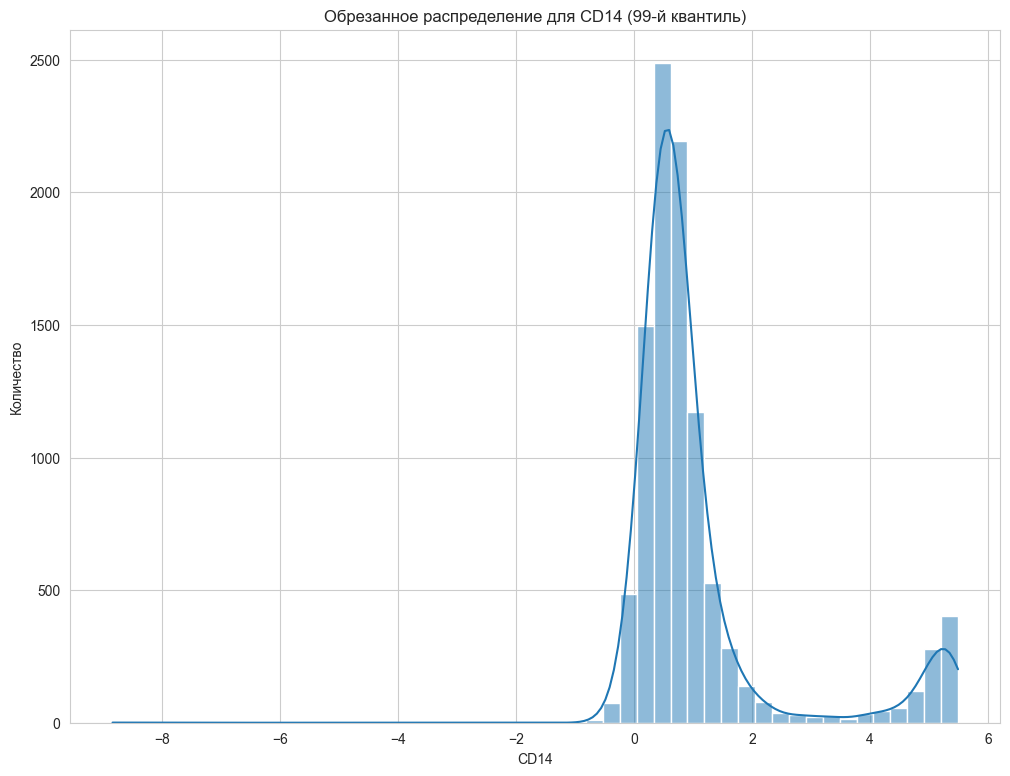

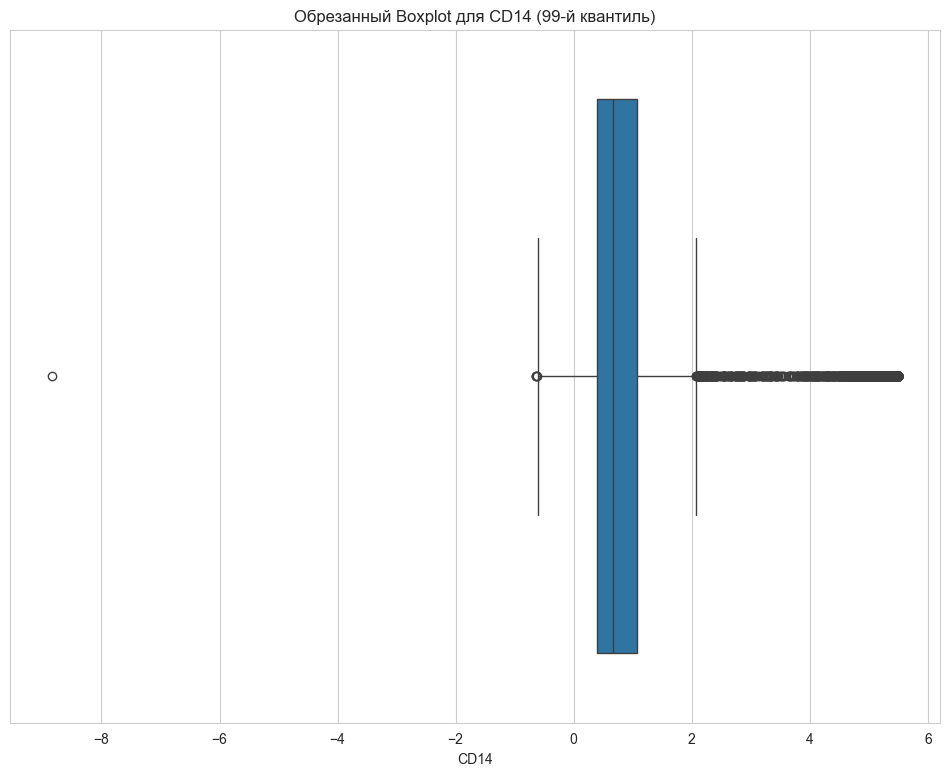

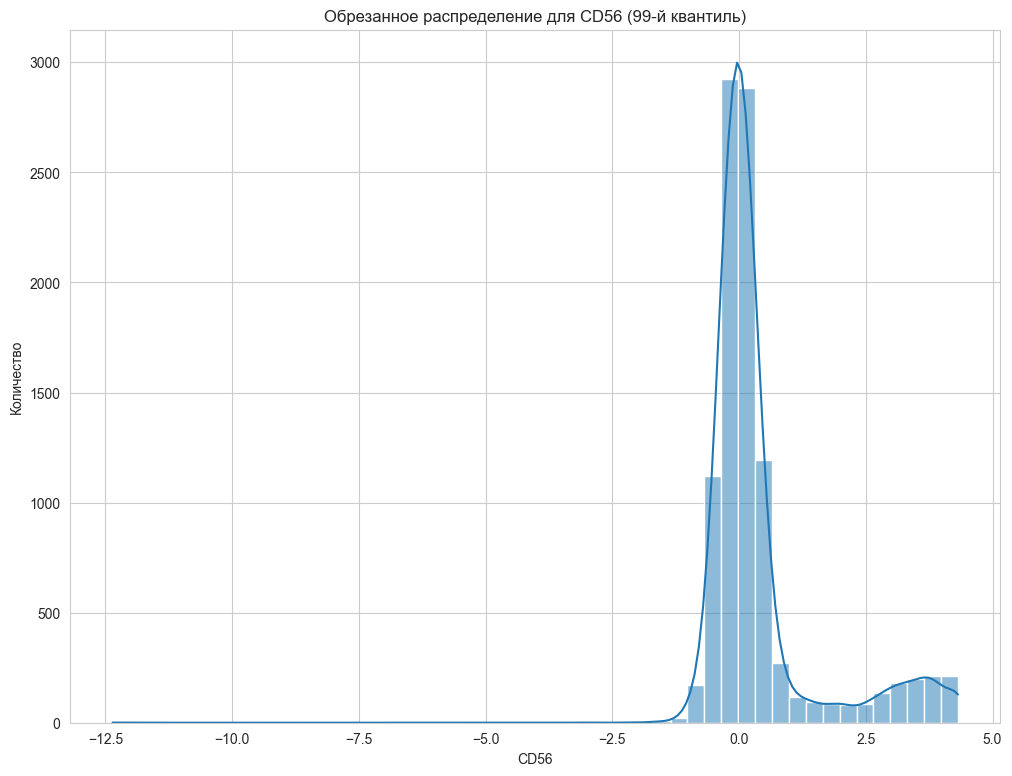

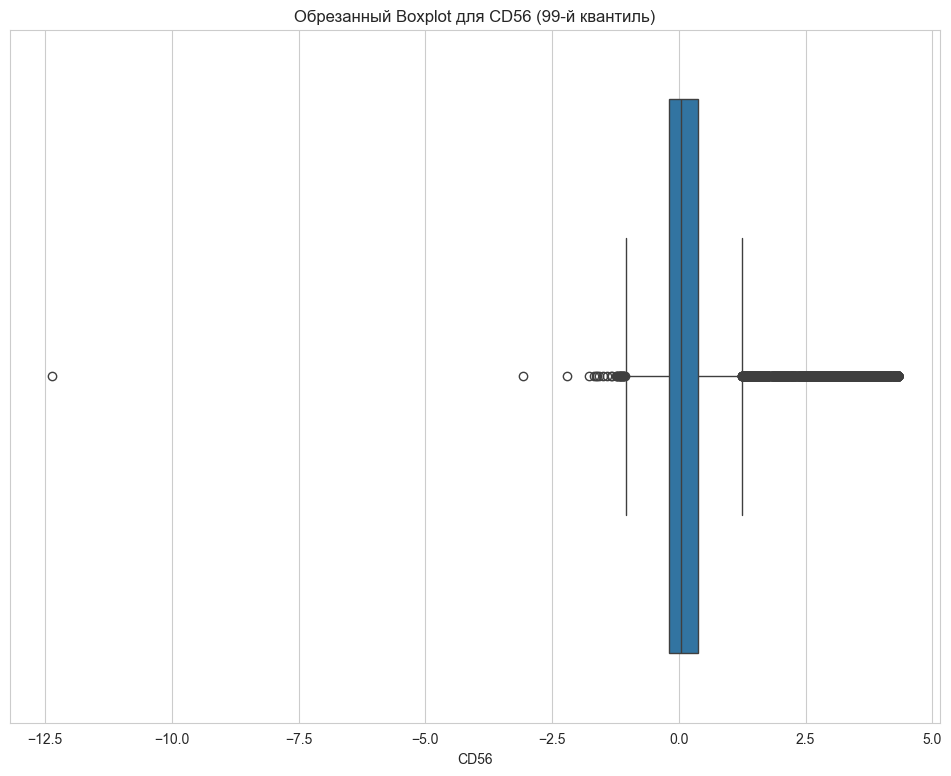

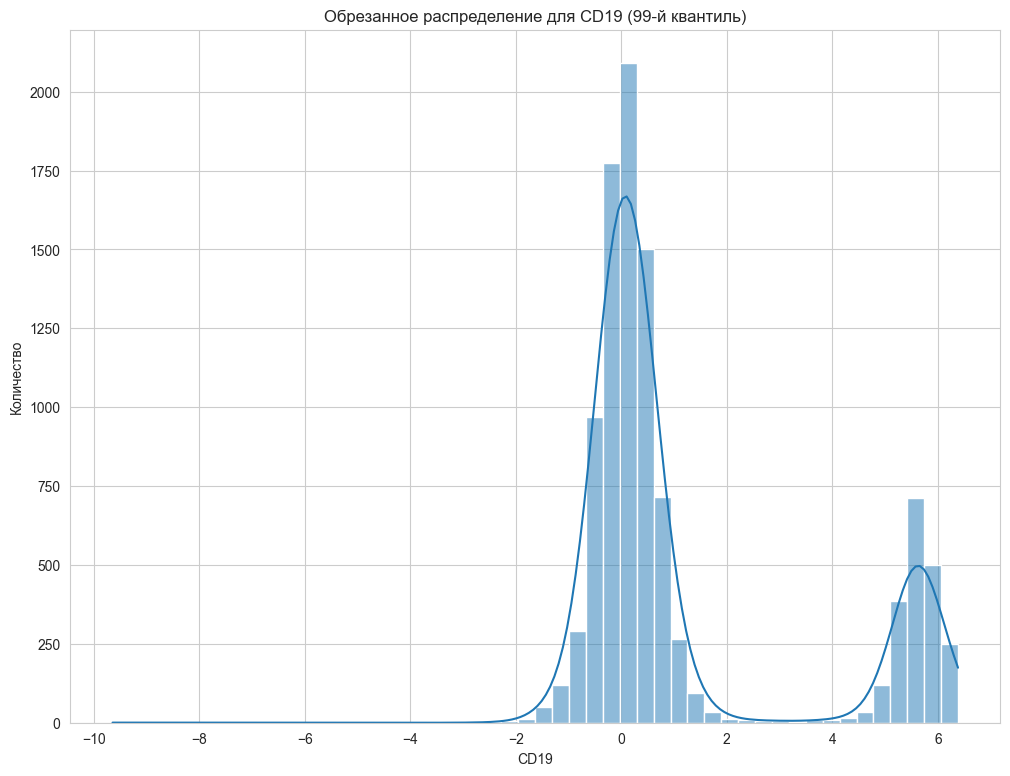

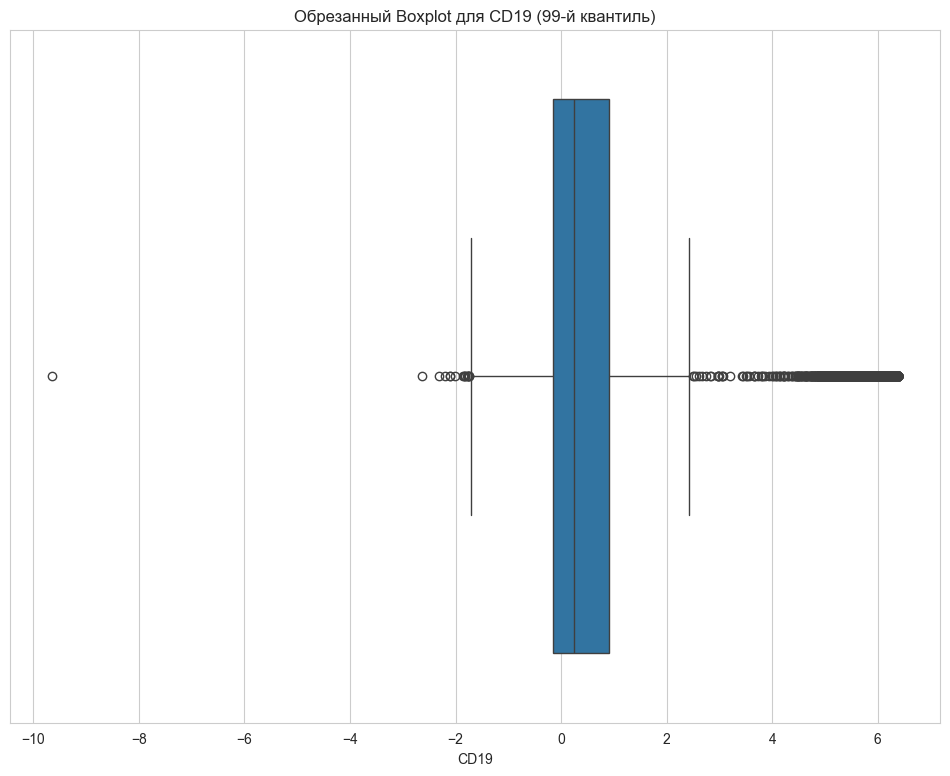

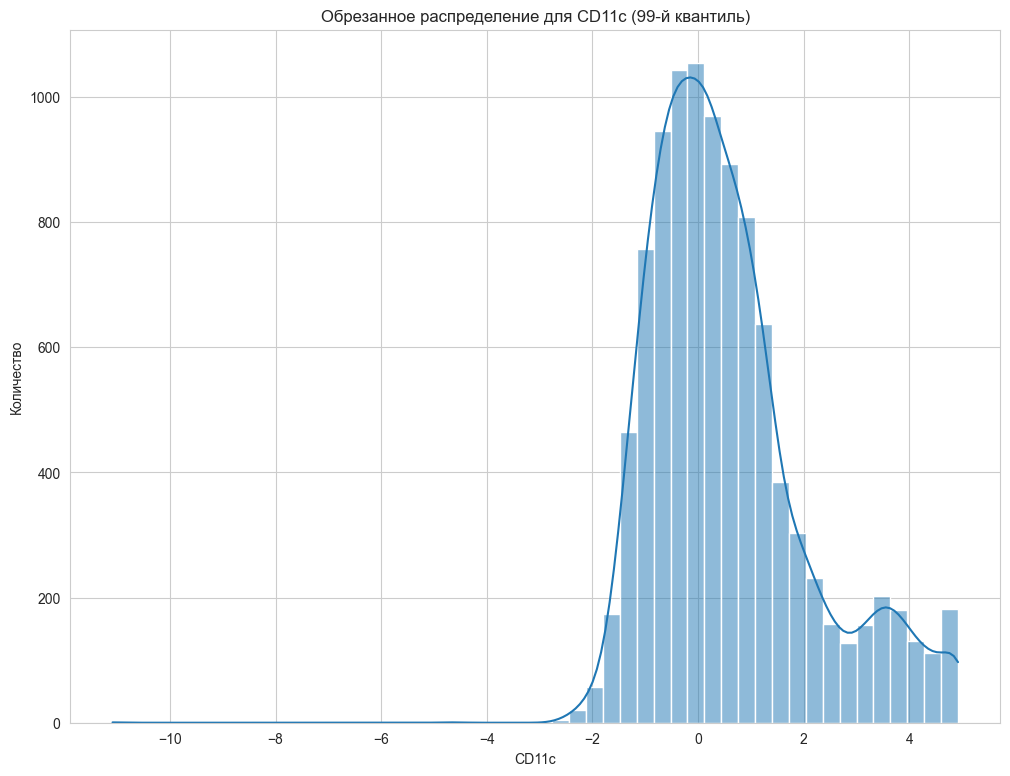

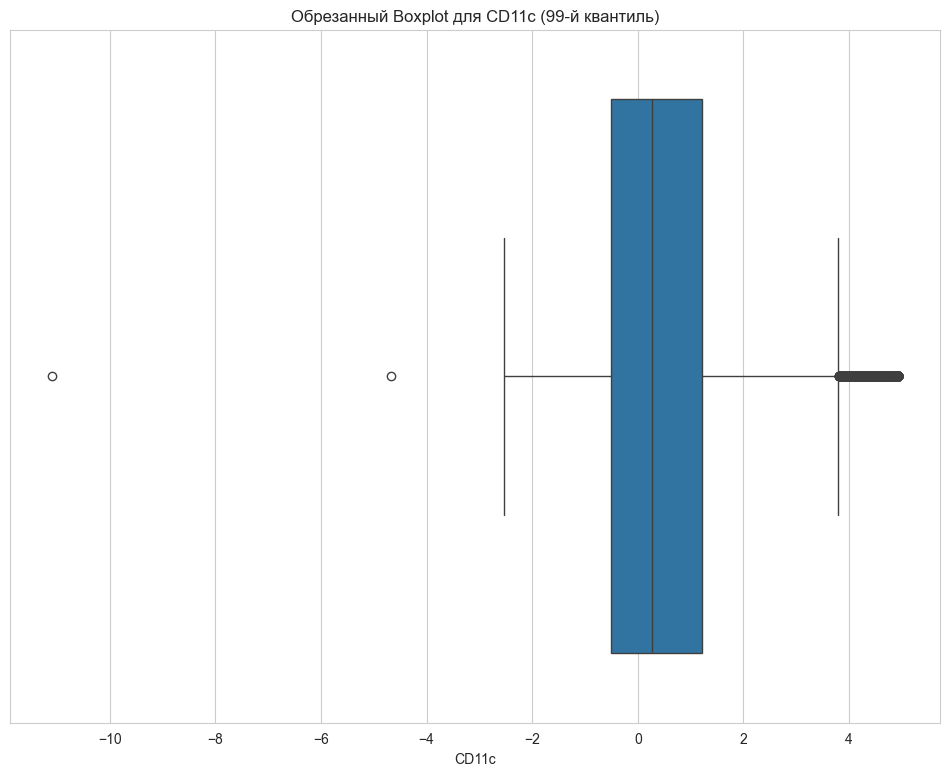

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_plot = ['FSC-A', 'SSC-A', 'HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19', 'CD11c']
quantile_99 = df[columns_to_plot].quantile(0.99)
df_clipped = df[columns_to_plot].clip(upper=quantile_99, axis=1)

for column in columns_to_plot:
    sns.histplot(df_clipped[column], bins=50, kde=True)
    plt.title(f'Обрезанное распределение для {column} (99-й квантиль)')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.show()
    sns.boxplot(data=df_clipped, x=column)
    plt.title(f'Обрезанный Boxplot для {column} (99-й квантиль)')
    plt.xlabel(column)
    plt.show()

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [50]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

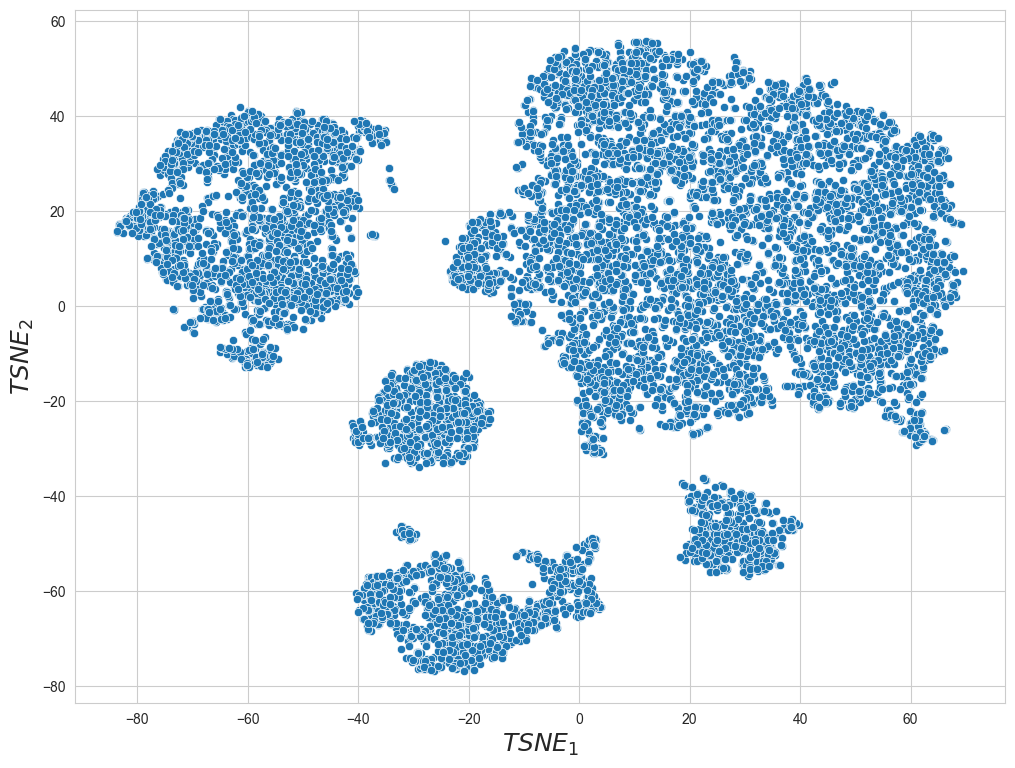

In [51]:
tsne_res = plot_tsne(df)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [52]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import silhouette_score
clusters_range = range(2, 10)
kmeans_results = []
agglomerative_results = []
dbscan_results = []
affinity_propagation_results = []

for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(df)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df, labels)
    kmeans_results.append((n_clusters, silhouette_avg))

for n_clusters in clusters_range:
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters).fit(df)
    labels = agglomerative.labels_
    silhouette_avg = silhouette_score(df, labels)
    agglomerative_results.append((n_clusters, silhouette_avg))

eps_values = [0.5, 1, 1.5, 2]  
for eps in eps_values:
    dbscan = DBSCAN(eps=eps).fit(df)
    labels = dbscan.labels_
    if len(set(labels)) > 1 and len(set(labels)) < len(df):
        silhouette_avg = silhouette_score(df, labels)
    else:
        silhouette_avg = -1  
    dbscan_results.append((eps, silhouette_avg))

affinity_propagation = AffinityPropagation(random_state=42).fit(df)
labels = affinity_propagation.labels_
if len(set(labels)) > 1 and len(set(labels)) < len(df):
    silhouette_avg = silhouette_score(df, labels)
else:
    silhouette_avg = -1
affinity_propagation_results.append(('not_applicable', silhouette_avg))  

best_kmeans = max(kmeans_results, key=lambda item: item[1])
best_agglomerative = max(agglomerative_results, key=lambda item: item[1])
best_dbscan = max(dbscan_results, key=lambda item: item[1])
best_affinity_propagation = max(affinity_propagation_results, key=lambda item: item[1])

print("Лучший результат K-Means:", best_kmeans)
print("Лучший результат Agglomerative:", best_agglomerative)
print("Лучший результат DBSCAN:", best_dbscan)
print("Лучший результат Affinity Propagation:", best_affinity_propagation)

best_score = max(best_kmeans[1], best_agglomerative[1], best_dbscan[1], best_affinity_propagation[1])
if best_score == best_kmeans[1]:
    best_model = KMeans(n_clusters=best_kmeans[0], random_state=42)
elif best_score == best_agglomerative[1]:
    best_model = AgglomerativeClustering(n_clusters=best_agglomerative[0])
elif best_score == best_dbscan[1]:
    best_model = DBSCAN(eps=best_dbscan[0])
else:
    best_model = AffinityPropagation(random_state=42)

best_model.fit(df)
labels = best_model.labels_


Лучший результат K-Means: (3, 0.6088711650694462)
Лучший результат Agglomerative: (4, 0.6114468221314616)
Лучший результат DBSCAN: (2, 0.5661723990666704)
Лучший результат Affinity Propagation: ('not_applicable', 0.10553348488696838)


Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

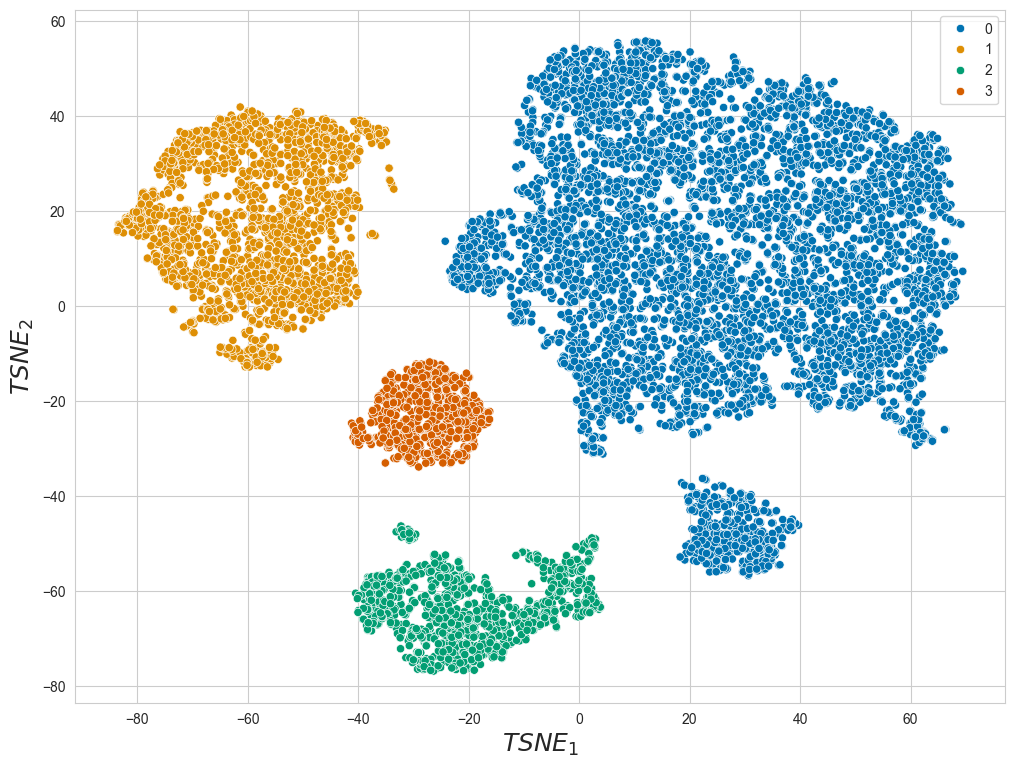

In [53]:
tsne_res = plot_tsne(data=df, color=labels)

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

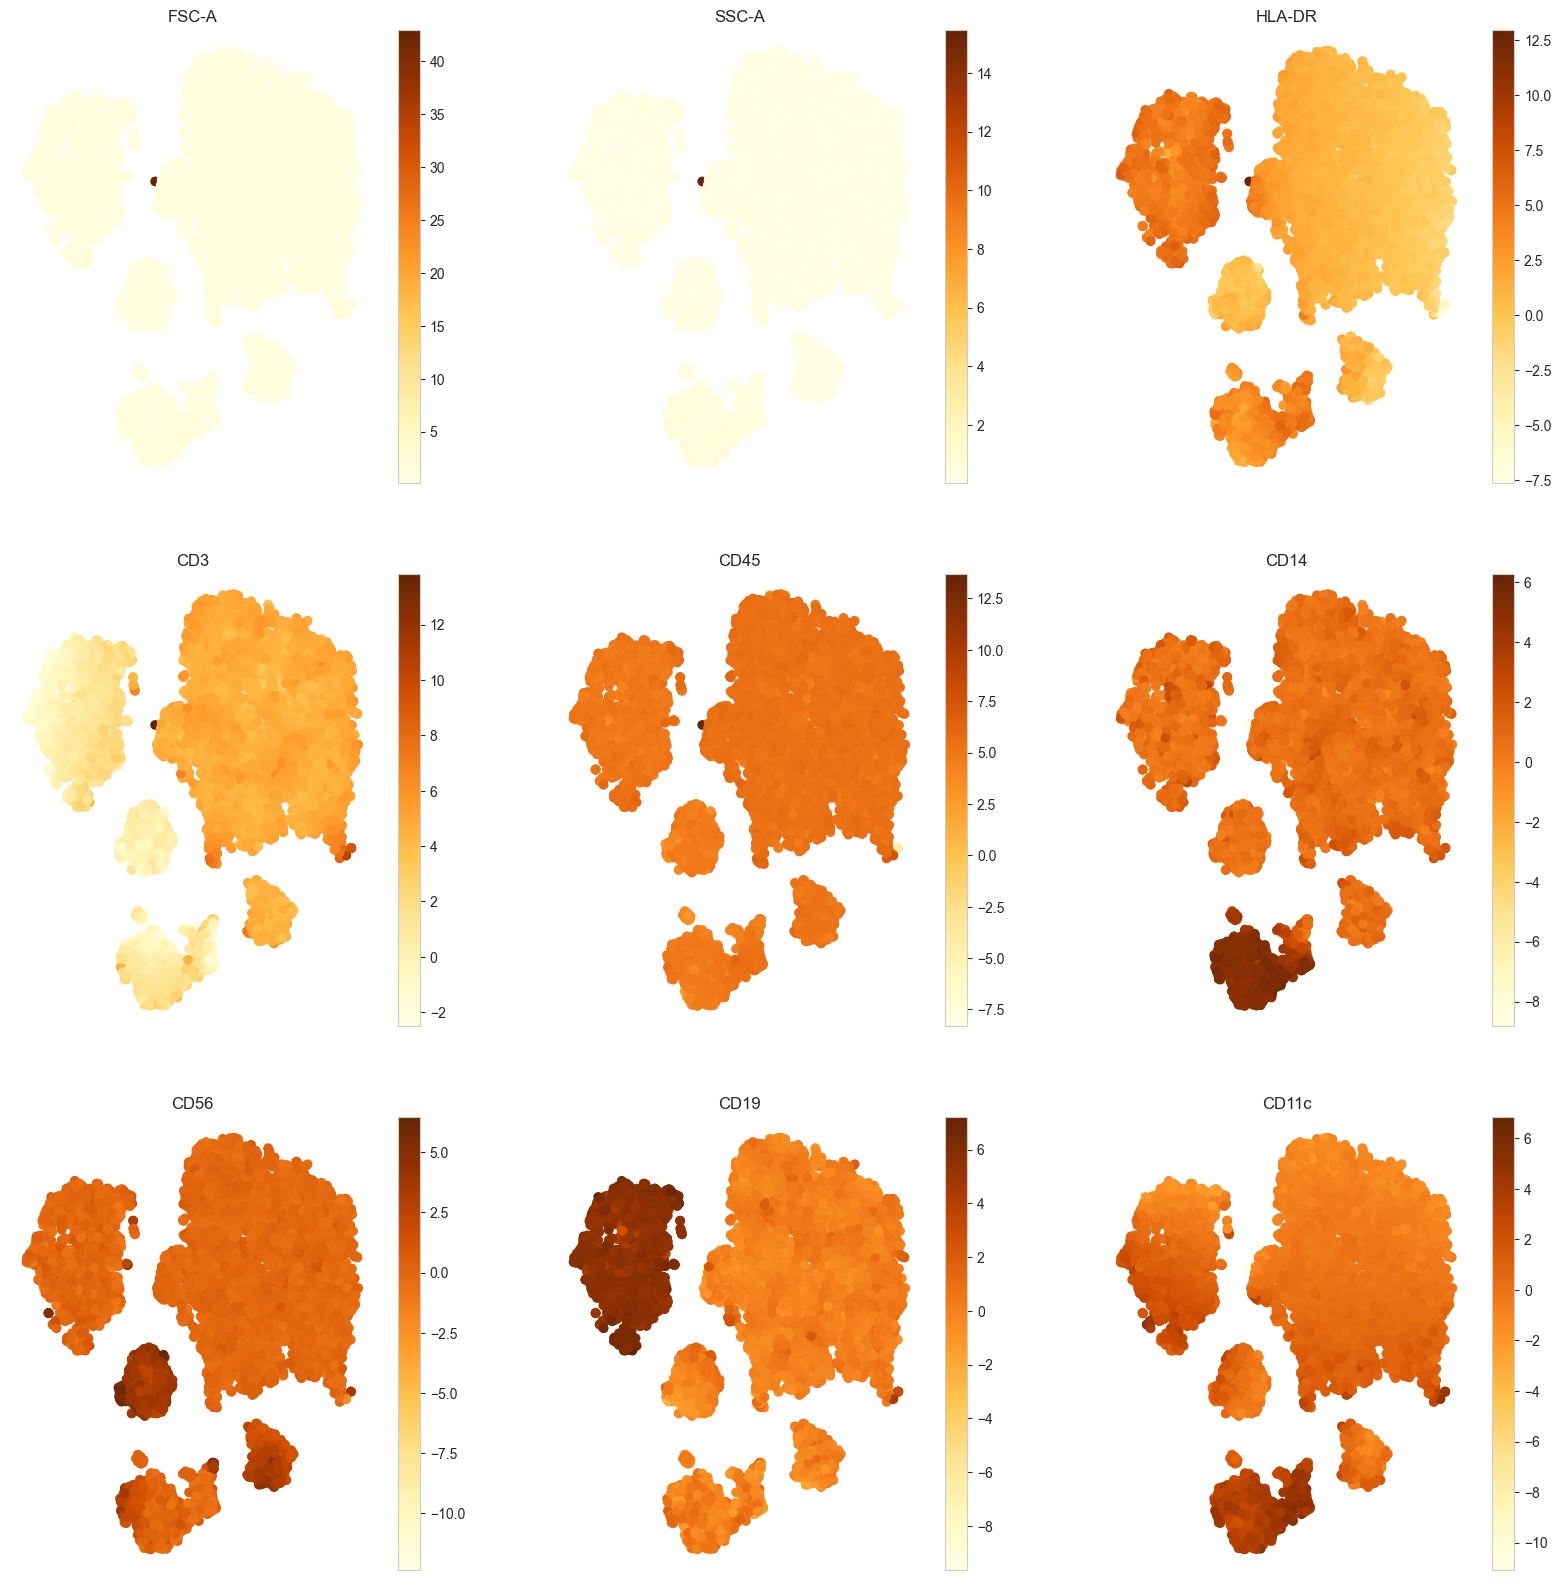

In [54]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(df.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=df[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

Честно говоря, я не очень понял задание, как имеено мы должны смаппить кластеры с типами клеток по маркерам(((

In [32]:
cell_type_cluster_map = {0: "B_cells", 
                         1: "T_cells", 
                         2: "Monocytes", 
                         3: "Other cells"}

In [55]:
labeled_fc_data = df.assign(Population=labels)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [56]:
cell_type_counts = labeled_fc_data["Population"].value_counts()

print(cell_type_counts)

Population
B_cells        6231
T_cells        2035
Monocytes      1099
Other cells     635
Name: count, dtype: int64


Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [58]:
labeled_fc_data.to_csv("flow_c_data_with_labels.csv")

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

X = labeled_fc_data.drop(['Population'], axis=1)
y = labeled_fc_data['Population']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
lr_classifier = LogisticRegression(random_state=42, class_weight='balanced', max_iter=10)
lr_classifier.fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"F1 Score (Macro): {f1:.4f}")

F1 Score (Macro): 1.0000


Что-то странное. Я взял обычную логистическую регрессию, но она слету выучила все признаки -- возможно в данных есть утечка, но у меня не осталось времени с этим разобраться

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Я не думаю, что весной получится это воплотить, но когда я жила в Тюмени, у нас появилась традиция ежегодно собираться в мае на природе большой компанией друзей в тюмеских базах отдыха или парках. В частности целым приключением было отдыхать в Гилевской роще, потому что помимо подготовки нужно было успеть занять лучшую беседку, из чего получалось много локальных приколов).
Сейчас я живу в Пущиино, но очень надесь, что в конце мая будет возможность снова попасть в эту теплую атмосферу. А в планах на всю остальную часть весны только учеба, работа и, возможно, конференция в Нижнем)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**